# GAN

#### Select processing devices

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICE"] = "0"

#### Load dependencies

In [2]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


/Users/krotovd/anaconda/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/krotovd/anaconda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


#### Load data

In [3]:
input_images = "../quickdraw_data/dolphin.npy"

In [4]:
data = np.load(input_images)

In [5]:
data.shape

(121613, 784)

In [6]:
data[420]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
data = data/255
data = np.reshape(data, (data.shape[0],28,28,1))#1 because these images are greyscale
img_w, img_h = data.shape[1:3]
data.shape

(121613, 28, 28, 1)

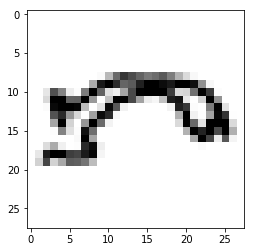

In [8]:
plt.imshow(data[420,:,:,0], cmap='Greys')

In [9]:
def discriminator_builder(depth=64, p=0.4):
    #Define inputs
    inputs = Input((img_w, img_h, 1))
    
    #conv laters
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    #output layer
    output = Dense(1, activation='sigmoid')(conv4)
    
    #model def
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [10]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [11]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, 
                                                                    decay=6e-8, 
                                                                    clipvalue=1.0),
                     metrics=['accuracy'])

#### Create generator network

In [12]:
def generator_builder(z_dim=100, depth=64, p=0.4):  #100 dimmensional latent space / p represents dropout rate
        #define inputs
        inputs = Input((z_dim,))
        
        #first dense layer
        dense1 = Dense(7*7*64)(inputs)
        dense1 = BatchNormalization(momentum=0.9)(dense1) #Helps maintain the mean and variabnce of the params
        dense1 = Activation(activation='relu')(dense1)
        dense1 = Reshape((7,7,64))(dense1)
        dense1 = Dropout(p)(dense1)
        
        #deconv layers
        conv1 = UpSampling2D()(dense1)
        conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None)(conv1)
        conv1 = BatchNormalization(momentum=0.9)(conv1)
        conv1 = Activation(activation='relu')(conv1)
        
        conv2 = UpSampling2D()(conv1)
        conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None)(conv2)
        conv2 = BatchNormalization(momentum=0.9)(conv2)
        conv2 = Activation(activation='relu')(conv2)
        
        conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None)(conv2)
        conv3 = BatchNormalization(momentum=0.9)(conv3)
        conv3 = Activation(activation='relu')(conv3)
        
        #output layer
        output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
        
        #model definition
        model = Model(inputs=inputs, outputs = output)
        model.summary()
        
        return model
        

In [13]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

#### Create adversarial network

In [14]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

In [15]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


#### Train!

In [16]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [17]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, 
                                                                    decay=6e-8, 
                                                                    clipvalue=1.0),
                                                         metrics=['accuracy'])
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, 
                                                                    decay=6e-8, 
                                                                    clipvalue=1.0),
                                                         metrics=['accuracy'])
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0


/Users/krotovd/anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
Epoch #500
499: [D loss: 7.968610, acc: 0.501010]  [A loss: 0.032301, acc: 1.000000]


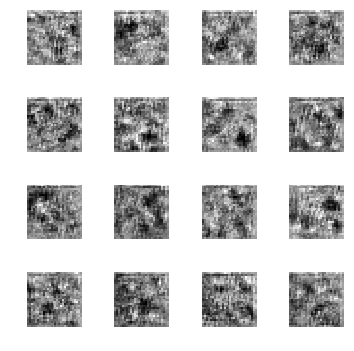

500
600


KeyboardInterrupt: 

In [18]:
a_metrics_complete, d_metrics_complete = train(epochs=3000)